[View in Colaboratory](https://colab.research.google.com/github/Josh-Joseph/test_colab/blob/master/train_and_evaluate_equal_ias_er_v1.ipynb)

# About this notebook

Our motivation is to show how, with a dead-simple subitition model and standard datasets we can create images that (while somewhat altered) are clearly recognizable by-human as faces but will fool remote APIs. In this notebook we demonstrate how to train and evaluate this face attack proof of concept based on the [Cleverhans](https://github.com/tensorflow/cleverhans) project. We hope this serves as a jumping off point for others to introduce more sophisticated models, datasets, and attacks to face recognition systems.

The notebook is organized into the following sections:

* Installation of required packages
* Creating an image attack using FGSM with a substitution model
  * Training the substituion model
     * Downloading and splitting the training data into train and dev
     * Training the substitution model
  * Wrapping the FGSM attack around the substitution model
* Visually demonstrating the effect of the attack on sample images
* Evaluation of the attack
  * Against our trained substitution model
  * Against local blackbox face detection models
  * Against remote blockbox face detection APIs
* Upload and attack your own image


# Installation of required packages

In [0]:
# Ensure we're in the correct directory
cd /content

/content


In [0]:
# Install dlib (a local blackbox face detection model)
!apt-get install build-essential cmake -y
!apt-get install libgtk-3-dev -y
!apt-get install libboost-all-dev -y
!pip install dlib

!pip install keras_tqdm

# Install Clarifai.com's python package (a remote blackbox face detection API)
!pip install clarifai

# Install Watson Cloud python packagge
!pip install watson-developer-cloud

# To fix an issue with an older version of Pillow
!pip install Pillow --upgrade
!pip install image --upgrade

# Install Cleverhans python package (for the model training and attack)
!pip install --upgrade -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

# Get our code
!git clone https://github.com/Josh-Joseph/test_colab.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.9.1-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgtk-3-dev is already the newest version (3.22.25-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-all-dev is already the newest version (1.62.0.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Found existing installation: Pillow 5.1.0
    Uninstalling Pillow-5.1.0:
      Successfully uninstalled Pillow-5.1.0
  Using cached Pillow-5.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 2.9.0
    Uninstalling Pillow-2.9.0:
      Successfully uninstalled Pillo

Requirement already up-to-date: pytz in /usr/local/lib/python3.6/dist-packages (from django->image)
Obtaining cleverhans from git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
  Updating ./src/cleverhans clone
Requirement already up-to-date: nose in /usr/local/lib/python3.6/dist-packages (from cleverhans)
Requirement already up-to-date: pycodestyle in /usr/local/lib/python3.6/dist-packages (from cleverhans)
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (from cleverhans)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (from cleverhans)
Requirement already up-to-date: numpy>=1.8.2 in /usr/local/lib/python3.6/dist-packages (from scipy->cleverhans)
Requirement already up-to-date: six>=1.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib->cleverhans)
Requirement already up-to-date: python-dateutil>=2.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib->cleverhans)
Requirement already up-t

# Creating an image attack using FGSM with a substitution model

## Downloading and splitting the training data into train and dev

In [1]:
# Ensure we're in the correct directory
cd /content

/content


In [2]:
# Ensure these don't exist already
!rm -r /content/datasets
!rm -r /content/raw_data

# Download/reorganize LFW
!. ./test_colab/data_scripts/download_lfw_raw.sh > /dev/null
!. ./test_colab/data_scripts/flatten_lfw_raw.sh > /dev/null

# Download/reorganize CIFAR10
!. ./test_colab/data_scripts/download_cifar-10.sh > /dev/null
!python ./test_colab/data_scripts/unpickle_cifar-10.py > /dev/null
!rm -rf ./raw_data/cifar-10-batches-py

# Download/reorganize our own "private proof" dataset
# !python ./test_colab/data_scripts/download_private_proof_v1.py > /dev/null


/bin/sh: 8: ./test_colab/data_scripts/download_lfw_raw.sh: :This script downloads the raw "Labeled Faces in the Wild" dataset

Dataset description:
13233 images
5749 people
1680 people with two or more images
250x250 pixel images
: not found
--2018-04-17 14:38:36--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘./raw_data/lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  74.1MB/s    in 2.3s    

2018-04-17 14:38:38 (74.1 MB/s) - ‘./raw_data/lfw.tgz’ saved [180566744/180566744]

/bin/sh: 2: ./test_colab/data_scripts/download_cifar-10.sh: :This downloads the Python version of CIFAR-10.
: not found
--2018-04-17 14:39:44--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.t

cifar-10-python.tar 100%[===================>] 162.60M  4.74MB/s    in 41s     

2018-04-17 14:40:25 (4.01 MB/s) - ‘./raw_data/cifar-10-python.tar.gz’ saved [170498071/170498071]



In [0]:
# Organize the data into train and dev datasets

import os
from pathlib import Path
import shutil
import random
from math import floor

dataset_name = 'faces_vs_all'

label_keys_map = {
    '0_nonface': [
        # '/content/raw_data/private_proof_v1/architecture',
        # '/content/raw_data/private_proof_v1/bag',
        # '/content/raw_data/private_proof_v1/font',
        # '/content/raw_data/private_proof_v1/insect',
        # '/content/raw_data/private_proof_v1/landscape',
        # '/content/raw_data/private_proof_v1/machinery',
        # '/content/raw_data/private_proof_v1/ring',
        '/content/raw_data/cifar-10/airplane',
        '/content/raw_data/cifar-10/automobile',
        '/content/raw_data/cifar-10/bird',
        '/content/raw_data/cifar-10/cat',
        '/content/raw_data/cifar-10/deer',
        '/content/raw_data/cifar-10/dog',
        '/content/raw_data/cifar-10/frog',
        '/content/raw_data/cifar-10/horse',
        '/content/raw_data/cifar-10/ship',
        '/content/raw_data/cifar-10/truck'
    ],
    '1_face': [
        '/content/raw_data/lfw'
    ]
}

valid_file_extensions = ['jpg', 'jpeg', 'png']

split_percentages = {'train': 80, 'dev': 20}

# replace the folders with their individual file paths
label_files_map = {}
for label, folder_paths in label_keys_map.items():
    assert type(folder_paths) is list
    label_files_map[label] = []
    for folder_path in folder_paths:
        files = sorted(Path(folder_path).iterdir())
        files = [f for f in files if f.suffix[1:].lower() in valid_file_extensions]
        label_files_map[label] += files
    assert len(label_files_map[label]) > 0

# split the individual file paths for train, dev, and (optionally) test
split = {'train': {}, 'dev': {}}
if 'test' in split_percentages:
    split['test'] = {}

# preferences for extra images due to rounding go test > dev > train
for label, refs in label_files_map.items():
    # Randomly mix the data for this label
    shuffled_refs = refs.copy()
    random.Random(1234).shuffle(shuffled_refs)

    train_split_index = floor(len(shuffled_refs) * split_percentages['train'] / 100)
    split['train'][label] = shuffled_refs[:train_split_index]
    remaining_refs = shuffled_refs[train_split_index:]

    if 'test' not in split_percentages:
        split['dev'][label] = remaining_refs
    else:
        dev_split_index = floor(len(remaining_refs) *
                                (split_percentages['dev'] / (100 - split_percentages['train'])))
        split['dev'][label] = remaining_refs[:dev_split_index]
        split['test'][label] = remaining_refs[dev_split_index:]

temp_processing_path = Path('/content/tmp')
temp_processing_path.mkdir(exist_ok=True)
temp_processing_path = Path('/content/datasets')
temp_processing_path.mkdir(exist_ok=True)
# copy the images into their final dataset directory
local_dataset_path = Path(temp_processing_path, dataset_name)
if os.path.exists(local_dataset_path.as_posix()):
    shutil.rmtree(local_dataset_path.as_posix())
for s in split.keys():
    for label in split[s].keys():
        s_label_folder = Path(local_dataset_path, s, label)
        s_label_folder.mkdir(parents=True)
        for image_source in split[s][label]:
            image_destination = Path(s_label_folder, Path(image_source).name)
            shutil.copy(image_source.as_posix(), image_destination.as_posix())

In [0]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image as pil_image

%matplotlib inline

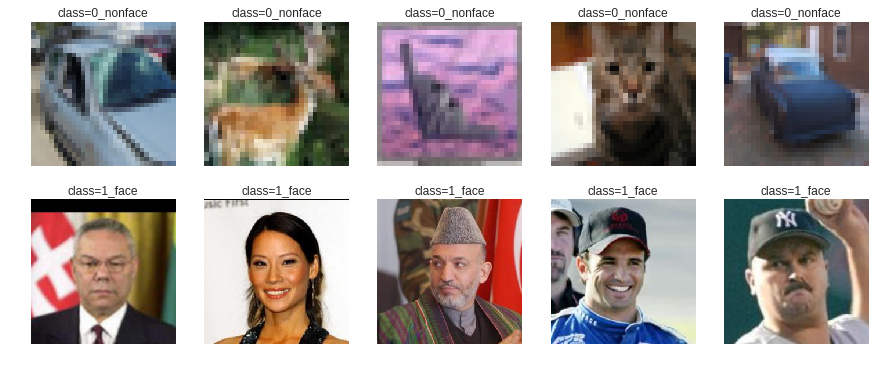

In [3]:
nonface_imgs = list(Path('/content/datasets/faces_vs_all/train/0_nonface/').iterdir())
face_imgs = list(Path('/content/datasets/faces_vs_all/train/1_face/').iterdir())
random.Random(10).shuffle(nonface_imgs)
random.Random(10).shuffle(face_imgs)

n_per_class = 5
fig, axes = plt.subplots(2, n_per_class, figsize=(15, 6))
for i in range(n_per_class):
    img = pil_image.open(Path(nonface_imgs[i]).as_posix())
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('class=0_nonface')
    
    img = pil_image.open(Path(face_imgs[i]).as_posix())
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('class=1_face')

## Training the substitution model

Note: If you get an error involving PIL or cleverhans when you execute the next few cells, restart the runtime and you should then be able to proceed without issue.

In [1]:
cd /content/test_colab

/content/test_colab


In [4]:
import sys
sys.path.append('/content/src/')

import datetime
import numpy as np
import tensorflow as tf
import keras as K

from cleverhans.utils_tf import model_train, model_eval
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model, KerasModelWrapper, conv_2d

from data_processing import import_images_from_directories

Using TensorFlow backend.


In [0]:
# Make sure we have a GPU attached
assert tf.test.gpu_device_name() == '/device:GPU:0'

In [6]:
dataset_path = '/content/datasets/faces_vs_all'

desired_image_size = (300, 300)

X_train, Y_train = import_images_from_directories(
    dataset_path + '/train', 
    resize_shape=desired_image_size, 
    max_images_per_class=2000
)
print("X_train shape, Y_train shape: {}, {}".format(X_train.shape, Y_train.shape))

X_test, Y_test = import_images_from_directories(
    dataset_path + '/dev', 
    resize_shape=desired_image_size, 
    max_images_per_class=100
)
print("X_test shape, Y_test shape: {}, {}".format(X_test.shape, Y_test.shape))

X_train shape, Y_train shape: (4000, 300, 300, 3), (4000, 2)
X_test shape, Y_test shape: (200, 300, 300, 3), (200, 2)


In [7]:
def evaluate():
    # Evaluate the accuracy of the model on legitimate test examples
    eval_params = {'batch_size': batch_size}
    acc = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
    report.clean_train_clean_eval = acc
    print('Test accuracy on legitimate examples: %0.4f' % acc)

num_classes = Y_train.shape[1]
n_epochs = 10
batch_size = 32
learning_rate = 0.0005

# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Create TF session and set as Keras backend session
sess = tf.Session()

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
rng = np.random.RandomState([2017, 8, 30])

K.backend.set_session(sess)
K.layers.core.K.set_learning_phase(0)

# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, desired_image_size[0], desired_image_size[1], 3))
y = tf.placeholder(tf.float32, shape=(None, num_classes))

channels = 3
nb_filters = 64 
model = K.Sequential()
model.add(K.layers.Convolution2D(nb_filters, (8, 8), strides=(2, 2), 
                                 padding="same", activation='relu', 
                                 input_shape=(desired_image_size[0], 
                                              desired_image_size[1], channels)))
model.add(K.layers.Convolution2D(nb_filters * 2, (6, 6), strides=(2, 2), 
                                 padding="valid", activation='relu'))
model.add(K.layers.Convolution2D(nb_filters * 2, (3, 3), strides=(2, 2), 
                                 padding="valid", activation='relu'))
model.add(K.layers.Convolution2D(nb_filters * 4, (3, 3), strides=(2, 2), 
                                 padding="valid", activation='relu'))
model.add(K.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(100))
model.add(K.layers.Dense(num_classes))
model.add(K.layers.Activation('softmax'))

print(model.summary())

preds = model(x)

saver = tf.train.Saver()

model_train(sess, x, y, preds, X_train, Y_train, evaluate=evaluate,
            args={'nb_epochs': n_epochs, 'batch_size': batch_size,  'learning_rate': learning_rate}, 
            rng=rng)
saver.save(sess, "./saved_model/model.ckpt".format(datetime.datetime.now().strftime('%Y%m%dT%H%M%S')))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      12352     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 73, 73, 128)       295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1638500   
__________

'./saved_model/model.ckpt'

## Wrapping the FGSM attack around the substitution mode

In [0]:
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)
eps = tf.placeholder(tf.float32)
adv_x = fgsm.generate(x, eps=eps, clip_min=0.0, clip_max=1.0)
adv_x = tf.stop_gradient(adv_x)

def fgsm_sub_attack_image(img, fgsm_eps=0.2):
    img = img.convert('RGB')
    orig_size = img.size
    img = img.resize(desired_image_size)
    img = np.asarray(img) / 255.0
    
    assert len(img.shape) == 3
    assert img.shape[0] == desired_image_size[0]
    assert img.shape[1] == desired_image_size[1]
    assert img.shape[2] == 3
    assert (0.0 <= img).all() and (img <= 1.0).all()
    
    attacked_img = sess.run(adv_x, feed_dict={x: [img], eps: fgsm_eps})[0]
    return pil_image.fromarray(np.uint8(attacked_img * 255)).resize(orig_size)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Visually demonstrating the effect of the attack on sample images

In [0]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image as pil_image

%matplotlib inline

In [0]:
def visualize_attack(img_path):
    img = pil_image.open(Path(img_path).as_posix())
    eps_vals = [0, 0.05, 0.1, 0.15, 0.2]
    fig, axes = plt.subplots(1, len(eps_vals), figsize=(15, 15))
    for i, e in enumerate(eps_vals):
        axes[i].imshow(fgsm_sub_attack_image(img, e))
        axes[i].axis('off')
        axes[i].set_title('eps={}'.format(e))

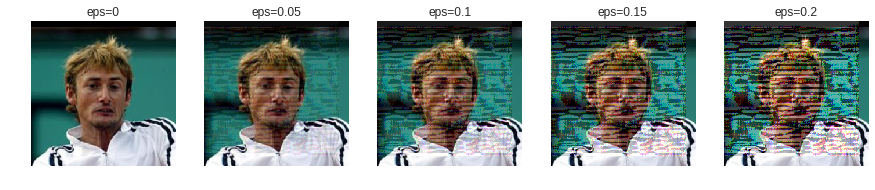

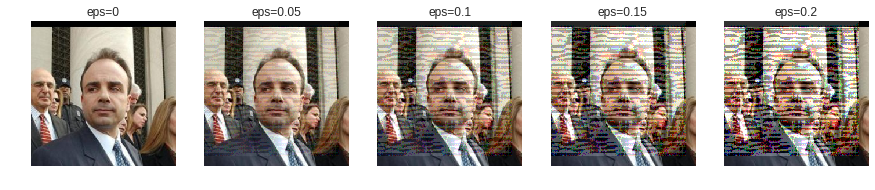

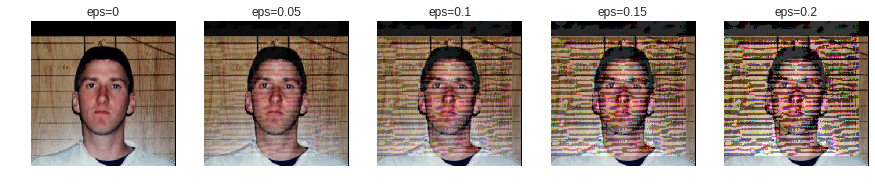

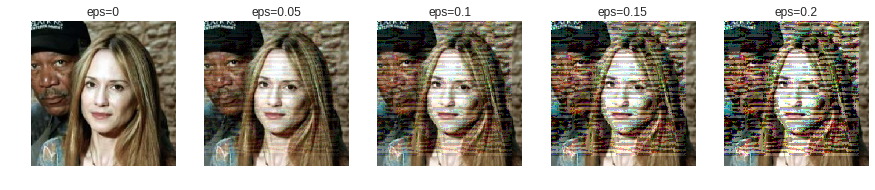

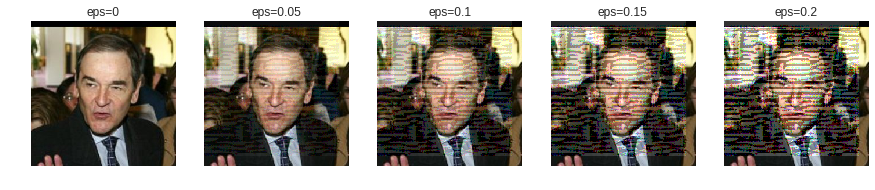

In [0]:
face_imgs = list(Path('/content/datasets/faces_vs_all/dev/1_face/').iterdir())
random.Random(12345).shuffle(face_imgs)

for face_img in face_imgs[:5]:
    visualize_attack(face_img)

# Evaluation of the attack

In [0]:
from face_detectors.face_detector import FaceDetector

In [0]:
def plot_effectiveness_vs_eps(detectors, eval_imgs):
    eps_vals = [0, 0.05, 0.1, 0.15, 0.2]
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    for detector in detectors:
        detections = []
        for e in eps_vals:
            detections.append(detector.evaluate_against(lambda img: fgsm_sub_attack_image(img, e), eval_imgs))
        axes.plot(eps_vals, detections, '.-', label=detector.name)
    axes.set_xlabel("FGSM's epsilon parameter")
    axes.set_ylabel('Fraction of faces detected')
    axes.set_title('FGSM effectiveness vs {} over a range of epsilon values'.format(detector.name))
    axes.set_ylim(-0.05, 1.05)
    axes.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

In [0]:
face_image_paths = list(Path('/content/datasets/faces_vs_all/dev/1_face/').iterdir())
random.Random(0).shuffle(face_image_paths)

eval_images = []
for img_path in face_image_paths[:100]:
    eval_images.append(pil_image.open(Path(img_path).as_posix()))
    
detectors = []

## Against our trained substitution model

In [0]:
class SubsitutionWhitebox(FaceDetector):
    
    name = 'subsitution_whitebox'
    
    def _detect_face(self, img):
        img = img.convert('RGB').resize(desired_image_size)
        img = np.asarray(img) / 255.0
        return np.argmax(sess.run(preds, feed_dict={x: np.asarray([img])})) == 1
    
detectors.append(SubsitutionWhitebox())

## Against local blackbox face detection models

In [0]:
from face_detectors import dlib_face_detector, cv2_cascade_face_detector

In [0]:
detectors.append(dlib_face_detector.DlibFaceDetector())
detectors.append(cv2_cascade_face_detector.CV2CascadeFaceDetector())

## Against remote blockbox face detection APIs

In [0]:
import io
import requests
from google.cloud import vision
from google.cloud.vision import types
from google.colab import files
from clarifai.rest import ClarifaiApp
from clarifai.rest import Image as ClImage
from watson_developer_cloud import VisualRecognitionV3

### Google Cloud Vision API

In [0]:
# Upload your Google credentials file
uploaded = files.upload()

for fn in uploaded.keys():
    filename = fn
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
%env GOOGLE_APPLICATION_CREDENTIALS=/content/test_colab/MELT-3265e45c6462.json

env: GOOGLE_APPLICATION_CREDENTIALS=/content/test_colab/MELT-3265e45c6462.json


In [0]:
class GoogleVisionFaceDetector(FaceDetector):
    
    name = 'google_cloud_vision_api'
    _client = vision.ImageAnnotatorClient()
    
    def _detect_face(self, img):
        # Convert the image to a byte_array
        bytes_buff = io.BytesIO()
        img.save(bytes_buff, 'PNG')
        img_byte_array = bytes_buff.getvalue()

        # Request
        image = types.Image(content=img_byte_array)
        response = self._client.face_detection(image=image)        
        return len(response.face_annotations) > 0
    
    
detectors.append(GoogleVisionFaceDetector())

### Microsoft Cognitive API

In [0]:
msft_api_key = ''

In [0]:
class MicrosoftCognitiveFaceDetector(FaceDetector):
    
    name = 'msft_cognitive_face_api'
    _face_api_url = 'https://eastus.api.cognitive.microsoft.com/face/v1.0/detect'
    _api_key = msft_api_key
    
    def _detect_face(self, img):
        # Convert the image to a byte_array
        bytes_buff = io.BytesIO()
        img.save(bytes_buff, 'PNG')

        # Request
        headers = {'Content-Type': 'application/octet-stream', 
                   'Ocp-Apim-Subscription-Key': self._api_key}
        params = {'returnFaceId': 'true',
                  'returnFaceLandmarks': 'false',
                  'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise'}
        image_file = io.BufferedReader(io.BytesIO(bytes_buff.getvalue()))
        response = requests.post(self._face_api_url, params=params, headers=headers, data=image_file)
        faces = response.json()
        return len(faces) != 0
    
    
detectors.append(MicrosoftCognitiveFaceDetector())

### Clarifai Face Detector API

In [0]:
clarifai_api_key = ''

In [0]:
class ClarifaiFaceDetector(FaceDetector):
    
    name = 'clarifai_face-v1.3'
    _app = ClarifaiApp(api_key=clarifai_api_key)
    _model = _app.models.get("face-v1.3")
    
    def _detect_face(self, img):
        # Convert the image to a byte_array
        bytes_buff = io.BytesIO()
        img.save(bytes_buff, 'PNG')

        # Request
        image = ClImage(file_obj=bytes_buff)
        results2 = self._model.predict([image])
        return 'regions' in results2['outputs'][0]['data']
    
detectors.append(ClarifaiFaceDetector())

### Watson Cloud API

In [0]:
watson_api_key = ''

In [0]:
class WatsonFaceDetector(FaceDetector):
    
    name = 'watson_vision_api'
    _model = visual_recognition = VisualRecognitionV3(
        '2016-05-20', api_key=watson_api_key)
    
    def _detect_face(self, img):
        # Convert the image to a byte_array
        bytes_buff = io.BytesIO()
        img.save(bytes_buff, 'PNG')

        # Request
        image_file = io.BufferedReader(io.BytesIO(bytes_buff.getvalue()))
        out = self._model.detect_faces(images_file=image_file)
        return len(out['images'][0]['faces']) != 0
    
    
detectors.append(WatsonFaceDetector())

## Overall

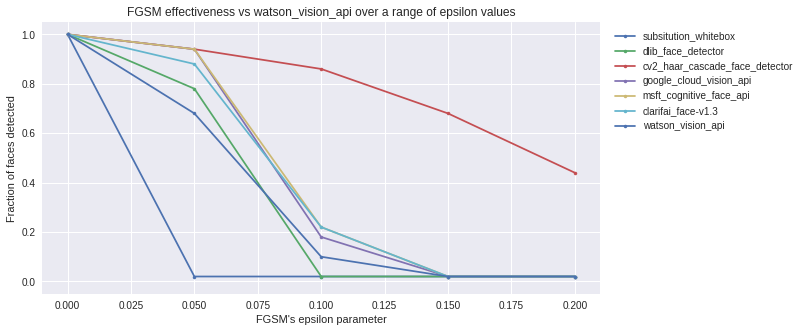

In [0]:
plot_effectiveness_vs_eps(detectors, eval_images[:25])

# Upload your own image

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
    filename = fn
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

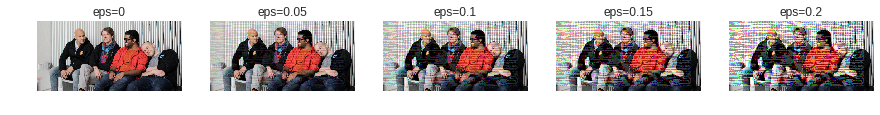

In [0]:
visualize_attack('./{}'.format(filename))